# Helsinki area home prices with Pycaret

Let's create a model to predict home prices in Helsinki area using Pycaret. This is a quite fast way to get a benchmark.

In [186]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import pycaret
import math
from datetime import datetime
from pycaret.regression import *

from helpers import process_data, get_missing_data, getElevatorImputing, drop_unique_area_rows

# Read data

In [187]:
orig_df = pd.read_csv('../data/house_data.csv')
# Same processing as in EDA
orig_df = process_data(orig_df)
orig_df.head()

,Item_id,House_type,Area,City,Price,Size,Year_build,Item_fetched,Latitude,Longitude,Condition,Dist_to_Hki_center,See_view,Subway,Total_size,Plot,Elevator
0,10001214,Block of flats,Leppävaara,Espoo,184800.0,32.0,2024.0,2022-05-14,60.222671,24.841161,Good,13460.533944,0.0,0,NaN,Rented,1.0
1,10001215,Block of flats,Leppävaara,Espoo,182500.0,30.5,2024.0,2023-01-07,60.222671,24.841161,Good,13460.533944,0.0,0,NaN,Rented,1.0
2,10001221,Block of flats,Leppävaara,Espoo,406700.0,67.5,2024.0,2023-01-07,60.222671,24.841161,Good,13460.533944,0.0,0,NaN,Rented,1.0
3,10001224,Block of flats,Leppävaara,Espoo,427400.0,67.5,2024.0,2022-02-26,60.222671,24.841161,Good,13460.533944,0.0,0,NaN,Rented,1.0
4,10001226,Block of flats,Leppävaara,Espoo,544900.0,84.0,2024.0,2022-04-16,60.222671,24.841161,Good,13460.533944,0.0,0,NaN,Rented,1.0


## Restrict to Helsinki area

In [188]:
# Make a copy of original data for later use
df = orig_df.copy()
df = df.loc[df.City.isin(['Helsinki','Espoo','Vantaa','Kauniainen','Tuusula','Nurmijarvi','Sipoo','Vihti','Kirkkonummi'])]
print(df.shape)
df.City.value_counts()

(20434, 17)


Helsinki       11797
Espoo           6054
Vantaa          1609
Tuusula          236
Kirkkonummi      209
Nurmijarvi       202
Sipoo            118
Vihti            109
Kauniainen       100
Name: City, dtype: int64

# Imputing

## Inspect missing data percentages

In [173]:
get_missing_data(df)

,Missing Ratio
Elevator,21.870412
Total_size,13.174122
Dist_to_Hki_center,3.381619
Plot,2.755212
Condition,2.246256
Latitude,1.463248
Longitude,1.257708
Year_build,0.332779
Area,0.039150


## Impute Elevator

In [174]:
# Assume there is no elevator in other than flats
df.loc[df.Elevator.isna() & (df.House_type != 'Kerrostalo'),'Elevator'] = 0

# For flats, impute elevator with mode per year built
imp = getElevatorImputing(df)
df.Elevator = df.Elevator.fillna(df.Year_build.map(imp))

#Check remaining missing values if any 
get_missing_data(df)

,Missing Ratio
Total_size,13.174122
Dist_to_Hki_center,3.381619
Plot,2.755212
Condition,2.246256
Latitude,1.463248
Longitude,1.257708
Year_build,0.332779
Area,0.039150


## Create new feature from Total_size

In [175]:
# Size and Total_size are highly correlated. Since we want to avoid multicollinearity but not loose information, we'll calculate the size of other spaces
df['Size_of_other_spaces'] = 0
df.loc[df.Total_size.notna(),'Size_of_other_spaces'] = df.loc[df.Total_size.notna(),'Total_size'] - df.loc[df.Total_size.notna(),'Size']
df.loc[df.Size_of_other_spaces<0,'Size_of_other_spaces'] = 0
df.Size_of_other_spaces.value_counts()

0.0      18725
5.0         96
4.0         51
20.0        50
3.0         38
         ...  
15.9         1
76.3         1
227.5        1
135.0        1
6.7          1
Name: Size_of_other_spaces, Length: 309, dtype: int64

In [176]:
df = df.drop('Total_size',axis = 1)

## The rest of Nones

In [177]:
get_missing_data(df)

,Missing Ratio
Dist_to_Hki_center,3.381619
Plot,2.755212
Condition,2.246256
Latitude,1.463248
Longitude,1.257708
Year_build,0.332779
Area,0.039150


In [178]:
# There are not many Nones left. Simple imputing by Pycaret could work well but since we have quite much data, we drop them to speed up the training
df = df.dropna().reset_index(drop=True)
df.shape

(18474, 17)

# Manual encodings and conversions
## Encoding some categorical variables

In [179]:
# Home condition is ordinal 
condit = {}
condit['Good'] = 3
condit['Satisfactory'] = 2
condit['Adequate'] = 1
condit

df['Condition'] = df['Condition'].replace(condit)
     
print('Shape df: {}'.format(df.shape))
display(df.head())

Shape df: (18474, 17)


,Item_id,House_type,Area,City,Price,Size,Year_build,Item_fetched,Latitude,Longitude,Condition,Dist_to_Hki_center,See_view,Subway,Plot,Elevator,Size_of_other_spaces
0,10001214,Block of flats,Leppävaara,Espoo,184800.0,32.0,2024.0,2022-05-14,60.222671,24.841161,3,13460.533944,0.0,0,Rented,1.0,0.0
1,10001215,Block of flats,Leppävaara,Espoo,182500.0,30.5,2024.0,2023-01-07,60.222671,24.841161,3,13460.533944,0.0,0,Rented,1.0,0.0
2,10001221,Block of flats,Leppävaara,Espoo,406700.0,67.5,2024.0,2023-01-07,60.222671,24.841161,3,13460.533944,0.0,0,Rented,1.0,0.0
3,10001224,Block of flats,Leppävaara,Espoo,427400.0,67.5,2024.0,2022-02-26,60.222671,24.841161,3,13460.533944,0.0,0,Rented,1.0,0.0
4,10001226,Block of flats,Leppävaara,Espoo,544900.0,84.0,2024.0,2022-04-16,60.222671,24.841161,3,13460.533944,0.0,0,Rented,1.0,0.0


## Encode plot
Pycaret would automatically encode this but since we want to make sure 1 eqauls own, we'll do it here

In [180]:
plot_vals = {}
plot_vals['Rented'] = 0
plot_vals['Own'] = 1
plot_vals

df['Plot'] = df['Plot'].replace(plot_vals)
     
print('Shape df: {}'.format(df.shape))
display(df.Plot.value_counts())

Shape df: (18474, 17)


1    12659
0     5815
Name: Plot, dtype: int64

## Date (Item_fetched) to numerical

In [181]:
df['Item_fetched'] = pd.to_datetime(df['Item_fetched'])
df['conv_date'] = df['Item_fetched'].map(datetime.toordinal)
df = df.drop(['Item_fetched'],axis = 1)
df.cov_date = df.conv_date.astype(float)
df.head()

,Item_id,House_type,Area,City,Price,Size,Year_build,Latitude,Longitude,Condition,Dist_to_Hki_center,See_view,Subway,Plot,Elevator,Size_of_other_spaces,conv_date
0,10001214,Block of flats,Leppävaara,Espoo,184800.0,32.0,2024.0,60.222671,24.841161,3,13460.533944,0.0,0,0,1.0,0.0,738289
1,10001215,Block of flats,Leppävaara,Espoo,182500.0,30.5,2024.0,60.222671,24.841161,3,13460.533944,0.0,0,0,1.0,0.0,738527
2,10001221,Block of flats,Leppävaara,Espoo,406700.0,67.5,2024.0,60.222671,24.841161,3,13460.533944,0.0,0,0,1.0,0.0,738527
3,10001224,Block of flats,Leppävaara,Espoo,427400.0,67.5,2024.0,60.222671,24.841161,3,13460.533944,0.0,0,0,1.0,0.0,738212
4,10001226,Block of flats,Leppävaara,Espoo,544900.0,84.0,2024.0,60.222671,24.841161,3,13460.533944,0.0,0,0,1.0,0.0,738261


# Pycaret
We have done some imputing but most of the preprocessing is left for Pycaret

## First without transforming the target
Let's find the best model without target transformation or any other settings

In [118]:
reg_basic = setup(df.drop('Item_id',axis = 1), target = 'Price',session_id = 654321)

,Description,Value
0,Session id,654321
1,Target,Price
2,Target type,Regression
3,Original data shape,"(18474, 16)"
4,Transformed data shape,"(18474, 30)"
5,Transformed train set shape,"(12931, 30)"
6,Transformed test set shape,"(5543, 30)"
7,Numeric features,12
8,Categorical features,3
9,Preprocess,True


In [119]:
best_basic=compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,37022.6271,3785045607.0148,61366.6516,0.9193,0.1349,0.1020,0.1190
et,Extra Trees Regressor,37556.1182,4271675243.3212,65206.7325,0.9089,0.1406,0.1031,0.4290
rf,Random Forest Regressor,40712.3831,4775113577.2161,68993.2459,0.8981,0.1518,0.1135,0.2790
gbr,Gradient Boosting Regressor,45752.0749,5329330518.9929,72886.3081,0.8863,0.1654,0.1285,0.1480
dt,Decision Tree Regressor,55456.3536,9084012424.9507,95173.0970,0.8062,0.2098,0.1531,0.0830
lr,Linear Regression,79818.4697,13578441464.9017,116398.3380,0.7094,0.3668,0.2449,2.4790
lasso,Lasso Regression,79817.8088,13578429400.5495,116398.2708,0.7094,0.3668,0.2448,0.0910
ridge,Ridge Regression,79815.7370,13578219175.6378,116397.3819,0.7094,0.3673,0.2448,0.0930
llar,Lasso Least Angle Regression,79817.9018,13578457585.6605,116398.3759,0.7094,0.3669,0.2448,0.1060
br,Bayesian Ridge,79819.3683,13582569899.5665,116416.0128,0.7093,0.3676,0.2447,0.1040


## With log target transformation

We use normal log transformation since the data cannot include zeros and Pycaret's own target transformation is rather slow

In [120]:
df_trans = df.drop('Item_id',axis = 1).copy()
df_trans["Price_log"] = np.log(df_trans["Price"])
df_trans = df_trans.drop('Price',axis = 1)

In [121]:
reg_log = setup(df_trans, target = 'Price_log',session_id = 654321)
best_log = compare_models()

,Description,Value
0,Session id,654321
1,Target,Price_log
2,Target type,Regression
3,Original data shape,"(18474, 16)"
4,Transformed data shape,"(18474, 30)"
5,Transformed train set shape,"(12931, 30)"
6,Transformed test set shape,"(5543, 30)"
7,Numeric features,12
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0950,0.0167,0.1291,0.9377,0.0094,0.0075,0.0900
et,Extra Trees Regressor,0.0973,0.0190,0.1376,0.9292,0.0100,0.0077,0.3100
rf,Random Forest Regressor,0.1067,0.0223,0.1492,0.9168,0.0109,0.0084,0.2230
gbr,Gradient Boosting Regressor,0.1159,0.0241,0.1550,0.9103,0.0113,0.0091,0.1610
dt,Decision Tree Regressor,0.1488,0.0453,0.2127,0.8309,0.0155,0.0118,0.0760
ada,AdaBoost Regressor,0.1778,0.0511,0.2259,0.8095,0.0165,0.0140,0.1070
lr,Linear Regression,0.1962,0.0649,0.2546,0.7578,0.0185,0.0155,0.1190
ridge,Ridge Regression,0.1962,0.0649,0.2546,0.7578,0.0185,0.0155,0.0910
br,Bayesian Ridge,0.1962,0.0649,0.2546,0.7578,0.0185,0.0155,0.0820
lar,Least Angle Regression,0.1987,0.0673,0.2592,0.7487,0.0188,0.0157,0.0780


Log-transformation improved R2 measure

<b>Best so far: best_log 0.9377 (transformed target)

### Will tuning the best model (transformed target) improve the result?

In [122]:
lightgbm = create_model('lightgbm', verbose = False) #verbose set to False to avoid printing score grid
lightgbm_tuned = tune_model(lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1089,0.0213,0.1458,0.9172,0.0107,0.0086
1,0.1138,0.0249,0.1579,0.9128,0.0115,0.0089
2,0.1083,0.0230,0.1517,0.9157,0.0111,0.0085
3,0.1130,0.0234,0.1529,0.9096,0.0112,0.0089
4,0.1156,0.0242,0.1556,0.9077,0.0113,0.0091
5,0.1157,0.0240,0.1548,0.9082,0.0114,0.0091
6,0.1055,0.0191,0.1380,0.9280,0.0101,0.0083
7,0.1191,0.0256,0.1601,0.9096,0.0118,0.0094
8,0.1116,0.0238,0.1541,0.9111,0.0113,0.0088


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


No improvement

## Try if using automatic outlier removal would improve the result

In [123]:
reg_no_outliers = setup(df_trans, target = 'Price_log', remove_outliers=True, session_id = 654321)
best_outliers = compare_models()

,Description,Value
0,Session id,654321
1,Target,Price_log
2,Target type,Regression
3,Original data shape,"(18474, 16)"
4,Transformed data shape,"(17827, 30)"
5,Transformed train set shape,"(12284, 30)"
6,Transformed test set shape,"(5543, 30)"
7,Numeric features,12
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0962,0.0175,0.1321,0.9348,0.0096,0.0076,0.0870
et,Extra Trees Regressor,0.0994,0.0201,0.1418,0.9249,0.0104,0.0079,0.2830
rf,Random Forest Regressor,0.1097,0.0238,0.1541,0.9112,0.0113,0.0087,0.2200
gbr,Gradient Boosting Regressor,0.1161,0.0243,0.1558,0.9094,0.0114,0.0092,0.1490
dt,Decision Tree Regressor,0.1520,0.0470,0.2168,0.8244,0.0158,0.0120,0.0810
ada,AdaBoost Regressor,0.1770,0.0512,0.2261,0.8091,0.0165,0.0140,0.1020
br,Bayesian Ridge,0.1950,0.0659,0.2566,0.7539,0.0186,0.0154,0.0860
lr,Linear Regression,0.1951,0.0659,0.2567,0.7538,0.0186,0.0154,0.1120
ridge,Ridge Regression,0.1950,0.0659,0.2567,0.7538,0.0186,0.0154,0.0790
knn,K Neighbors Regressor,0.2750,0.1368,0.3698,0.4891,0.0270,0.0217,0.1320


No improvement

## Try if using ordinal condition would improve

In [124]:
reg_ordinal = setup(df_trans, target = 'Price_log', ordinal_features = {'Condition':[1,2,3]},session_id = 654321)
best_ordinal = compare_models()

,Description,Value
0,Session id,654321
1,Target,Price_log
2,Target type,Regression
3,Original data shape,"(18474, 16)"
4,Transformed data shape,"(18474, 30)"
5,Transformed train set shape,"(12931, 30)"
6,Transformed test set shape,"(5543, 30)"
7,Ordinal features,1
8,Numeric features,12
9,Categorical features,3


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0950,0.0167,0.1291,0.9377,0.0094,0.0075,0.1140
et,Extra Trees Regressor,0.0973,0.0190,0.1376,0.9292,0.0100,0.0077,0.3410
rf,Random Forest Regressor,0.1067,0.0223,0.1492,0.9168,0.0109,0.0084,0.2680
gbr,Gradient Boosting Regressor,0.1159,0.0241,0.1550,0.9103,0.0113,0.0091,0.1880
dt,Decision Tree Regressor,0.1488,0.0453,0.2127,0.8309,0.0155,0.0118,0.1230
ada,AdaBoost Regressor,0.1778,0.0511,0.2259,0.8095,0.0165,0.0140,0.1260
lr,Linear Regression,0.1962,0.0649,0.2546,0.7578,0.0185,0.0155,0.1620
ridge,Ridge Regression,0.1962,0.0649,0.2546,0.7578,0.0185,0.0155,0.1270
br,Bayesian Ridge,0.1962,0.0649,0.2546,0.7578,0.0185,0.0155,0.1080
lar,Least Angle Regression,0.1987,0.0673,0.2593,0.7486,0.0188,0.0157,0.1030


Did not improve

## Try blending the best model 

In [125]:
reg_log = setup(df_trans, target = 'Price_log',session_id = 654321)

,Description,Value
0,Session id,654321
1,Target,Price_log
2,Target type,Regression
3,Original data shape,"(18474, 16)"
4,Transformed data shape,"(18474, 30)"
5,Transformed train set shape,"(12931, 30)"
6,Transformed test set shape,"(5543, 30)"
7,Numeric features,12
8,Categorical features,3
9,Preprocess,True


In [127]:
lightgbm_log = create_model('lightgbm', verbose = False)
et_log = create_model('et', verbose = False)
blend_top_2_log = blend_models(estimator_list = [lightgbm_log, et_log])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0842,0.0134,0.1157,0.9479,0.0084,0.0066
1,0.0905,0.0166,0.1290,0.9418,0.0094,0.0071
2,0.0877,0.0159,0.1260,0.9418,0.0092,0.0069
3,0.0899,0.0156,0.1251,0.9395,0.0091,0.0071
4,0.0936,0.0164,0.1280,0.9376,0.0093,0.0074
5,0.0931,0.0173,0.1317,0.9335,0.0097,0.0074
6,0.0851,0.0131,0.1145,0.9504,0.0084,0.0067
7,0.0932,0.0162,0.1274,0.9428,0.0093,0.0074
8,0.0910,0.0170,0.1304,0.9364,0.0095,0.0072


<b>Best so far: best_ordinal 0.9406 (blended top 2 transformed target)

In [128]:
rf_log = create_model('rf', verbose = False)

In [129]:
blend_top_3_log = blend_models(estimator_list = [lightgbm_log, et_log, rf_log])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0881,0.0148,0.1216,0.9424,0.0089,0.0070
1,0.0923,0.0173,0.1316,0.9394,0.0096,0.0073
2,0.0898,0.0169,0.1300,0.9381,0.0095,0.0071
3,0.0921,0.0165,0.1283,0.9363,0.0094,0.0073
4,0.0976,0.0177,0.1331,0.9325,0.0097,0.0077
5,0.0960,0.0184,0.1357,0.9295,0.0100,0.0076
6,0.0878,0.0141,0.1188,0.9466,0.0087,0.0069
7,0.0959,0.0172,0.1311,0.9394,0.0096,0.0076
8,0.0940,0.0181,0.1344,0.9324,0.0098,0.0074


Blending 2 improved the result, but 3 did not

# Evaluate the best model
Evaluate_model does not work with blended models so we'll evaluate the other blended model. 

In [130]:
evaluate_model(lightgbm_log)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

The R2 in the Test set is 0.937 which is quite a good result with just some lines of code.

In [131]:
evaluate_model(lightgbm_log)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Interpret model

Summary bee-swarm plot shows the global importance of each feature and the distribution of effect sizes

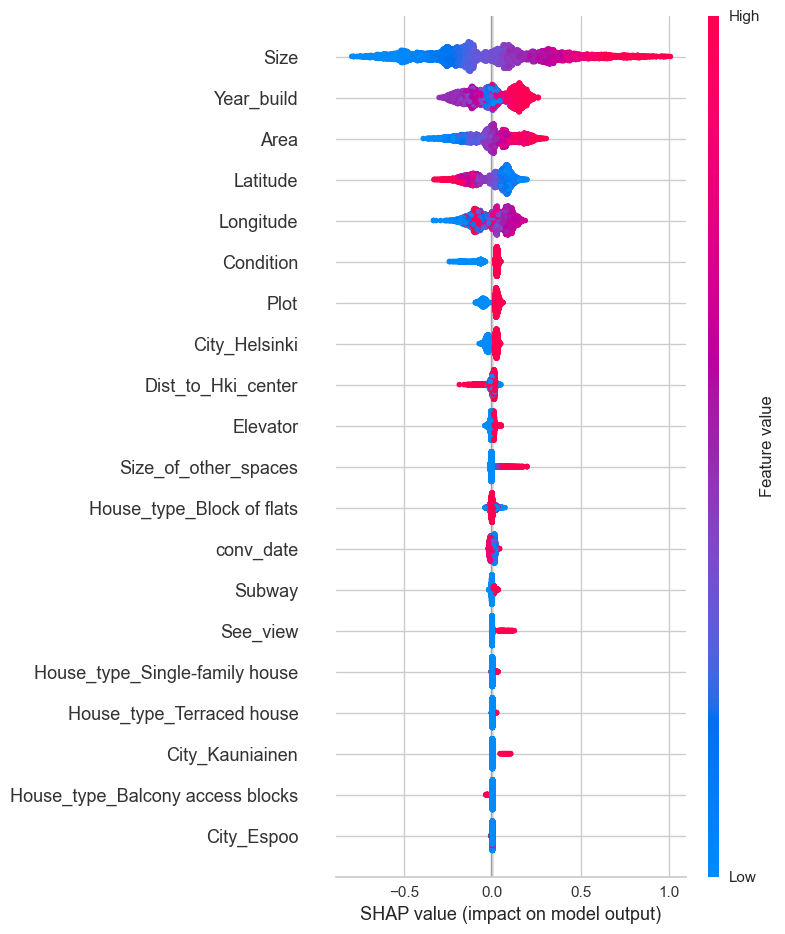

In [132]:
# Interpret_model does not support blended model so we'll inspect the best individual component in it
interpret_model(lightgbm_log)

Some findings:
- Size is the most important feature on average. Bigger size is likely to increase price and vice versa. 
- The second most important feature on average is build year. Newer homes are likely to have higher price. With older homes the situation is not so clear since their renovation status may be rather different. So homes in between are likely to have lower prices since they are not new but not renovated either.

# Finalize model
Finalizing the best model will use all data

In [133]:
final_blended = finalize_model(blend_top_2_log)

# Save the model

In [134]:
save_model(final_blended, '../models/'+datetime.today().strftime('%Y-%m-%d')+'_best_model_pycaret')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\clima\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Size', 'Year_build', 'Latitude',
                                              'Longitude', 'Condition',
                                              'Dist_to_Hki_center', 'See_view',
                                              'Subway', 'Plot', 'Elevator',
                                              'Size_of_other_spaces',
                                              'conv_date'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWr...
                 ('rest_encoding',
                  TransformerWrapper(include=['Area'],
                                     transformer=LeaveOneOutEncoder(cols=['Area'],
                                                                    handle_missing='return_nan',
                             

# Save predicted values for further investigation

In [182]:
predicted=predict_model(final_blended,data = df)
predicted.head()

,Item_id,House_type,Area,City,Price,Size,Year_build,Latitude,Longitude,Condition,Dist_to_Hki_center,See_view,Subway,Plot,Elevator,Size_of_other_spaces,conv_date,prediction_label
0,10001214,Block of flats,Leppävaara,Espoo,184800.0,32.0,2024.0,60.222672,24.841162,3,13460.53418,0.0,0,0,1.0,0.0,738289,12.213580
1,10001215,Block of flats,Leppävaara,Espoo,182500.0,30.5,2024.0,60.222672,24.841162,3,13460.53418,0.0,0,0,1.0,0.0,738527,12.171029
2,10001221,Block of flats,Leppävaara,Espoo,406700.0,67.5,2024.0,60.222672,24.841162,3,13460.53418,0.0,0,0,1.0,0.0,738527,12.913862
3,10001224,Block of flats,Leppävaara,Espoo,427400.0,67.5,2024.0,60.222672,24.841162,3,13460.53418,0.0,0,0,1.0,0.0,738212,12.934872
4,10001226,Block of flats,Leppävaara,Espoo,544900.0,84.0,2024.0,60.222672,24.841162,3,13460.53418,0.0,0,0,1.0,0.0,738261,13.143473


## Combine predictions with original data before encodings and transformations

In [183]:
result_df = orig_df.merge(predicted[['Item_id','prediction_label']], on = 'Item_id',how='left')
result_df.head()

,Item_id,House_type,Area,City,Price,Size,Year_build,Item_fetched,Latitude,Longitude,Condition,Dist_to_Hki_center,See_view,Subway,Total_size,Plot,Elevator,prediction_label
0,10001214,Block of flats,Leppävaara,Espoo,184800.0,32.0,2024.0,2022-05-14,60.222671,24.841161,Good,13460.533944,0.0,0,NaN,Rented,1.0,12.213580
1,10001215,Block of flats,Leppävaara,Espoo,182500.0,30.5,2024.0,2023-01-07,60.222671,24.841161,Good,13460.533944,0.0,0,NaN,Rented,1.0,12.171029
2,10001221,Block of flats,Leppävaara,Espoo,406700.0,67.5,2024.0,2023-01-07,60.222671,24.841161,Good,13460.533944,0.0,0,NaN,Rented,1.0,12.913862
3,10001224,Block of flats,Leppävaara,Espoo,427400.0,67.5,2024.0,2022-02-26,60.222671,24.841161,Good,13460.533944,0.0,0,NaN,Rented,1.0,12.934872
4,10001226,Block of flats,Leppävaara,Espoo,544900.0,84.0,2024.0,2022-04-16,60.222671,24.841161,Good,13460.533944,0.0,0,NaN,Rented,1.0,13.143473


In [184]:
result_df.to_csv('../data/'+datetime.today().strftime('%Y-%m-%d')+'_data_with_predictions.csv',index=False)